# Heat Transfer (L3)
**Mattia Sotgia<sup>1</sup>, Francesco Polleri <sup>1</sup>** \
_<sup>1</sup>Dipartimento di Fisica, Università degli studi di Genova_


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from data_util import Data

import ROOT
from iminuit import Minuit
from iminuit.cost import LeastSquares
import mplhep as hep

from scipy import fft

plt.style.use(['std-colors',hep.style.ATLAS])

Welcome to JupyROOT 6.24/02


## Analisi dati
Abbiamo acquisito 1200 punti (con frequenza di 10Hz) divisi in 4 dataset, divsi come
 - 2 dataaset (`20230321_1_1s` e `20230321_2_1s`) con impulso iniziale di ~1 s
 - 1 dataset con $\Delta_\text{pulse}$ = 0.5 e 1 dataset con 1.5 s

La `dataclass` Data contiene i dati necessari e anche una visualizzazione rapida, accessibile come `Data.prelim_plot()`, anche potendo esplorare limiti bassi e alti nei tempi. 

Importo i dati in un formato comodo per la trasformzione successiva. 

In [2]:
D1 = Data(np.loadtxt('data/20230321_1_1s.lvm', skiprows=23, unpack=True), 1)
D2 = Data(np.loadtxt('data/20230321_2_1s.lvm', skiprows=23, unpack=True), 1)
D3 = Data(np.loadtxt('data/20230321_3_1s.lvm', skiprows=23, unpack=True), 1)
D4 = Data(np.loadtxt('data/20230321_4_0.5s.lvm', skiprows=23, unpack=True), 0.5)
D5 = Data(np.loadtxt('data/20230321_5_1.5s.lvm', skiprows=23, unpack=True), 1.5)

Possiamo così rapidamente analizzare i valori ottenuti (per esempio osservo subito che la temperatura del PT100 risulta invariante rispetto al tempo)

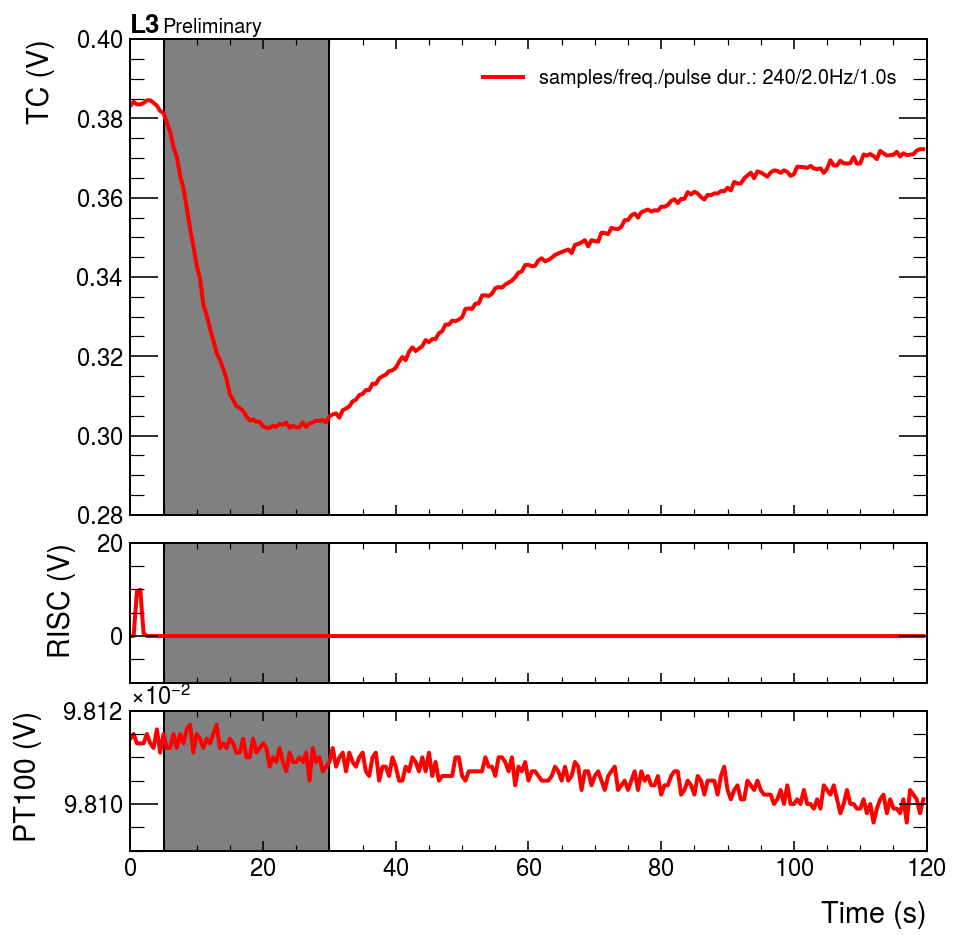

In [3]:
D3.prelim_plot(5, 30)

Data l'equazione per una sbarretta semi-infinita (correggo poi dopo con una restrizione del dominio), $$\frac{\partial T}{\partial t} = k \nabla T,$$ possiamo ottenere soluzione del tipo $$T(x,t) = \frac{C}{\sqrt{Dt}} \exp(-\frac{x^2}{4Dt}) + T_0.$$

In [27]:
class Analysis():
    bar_lenght: float = 63e-3
    TC_position: float = 23e-3
    
    def __init__(self, data: Data):
        self.data = data
        self.gain = 2000
        self.TC_conversion = 1/41e-6
    
    def filter(self, min_time: float = 0, max_time: float = 120):
        data = self.data
        if min_time < np.min(data.time):
            raise ValueError(f'{min_time = } is out of bounds')
        if max_time > np.max(data.time):
            raise ValueError(f'{max_time = } is out of bounds')
        
        low_index = np.where(data.time == min_time)[0][0]
        hi_index = np.where(data.time == max_time)[0][0]
        
        
        return Analysis(Data(
            [data.time[low_index:hi_index], 
             data.TC[low_index:hi_index], 
             data.RISC[low_index:hi_index], 
             data.PT100[low_index:hi_index]], 
            data.pulse_duration
        ))
    
    def plot_linearized(self):
        inverted_time = 1/self.data.time
        linearized_temperature = np.log(self.T('TC') * np.sqrt(self.data.time))
        plt.plot(inverted_time, linearized_temperature, label=f'(TC) {self.data.name}')
        plt.xlabel(r'$1/t$ (s$^{-1}$)')
        plt.ylabel(r'$\log(\sqrt{t}\cdot T_\mathrm{TC})$')
        
        return inverted_time, linearized_temperature
    
    def linearized_model_fit(self, signal_error=1, coefficient: float=1, offset: float=0):
        
        def model(x, α, β):
            return x * α + β
        
        x, y = self.plot_linearized()
        LSmodel = LeastSquares(x, y, 1, model)
        M1 = Minuit(LSmodel, α=coefficient, β=offset)
        M1.migrad()
        
        plt.clf()
        plt.errorbar(x, y, signal_error, None, 'ko', markersize=1.5, label=f'(TC) {self.data.name}')
        plt.xlabel(r'$1/t$ (s$^{-1}$)')
        plt.ylabel(r'$\log(\sqrt{t}\cdot T_\mathrm{TC})$')
        plt.plot(x, model(x, *M1.values), 'r')
        
        D = - self.TC_position**2 / (4 * M1.values['α'])
        
        return D, M1
    
    def T(self, which = 'TC'):
        def PT100_temp():
            data = self.data
            i_pt100 = 1/1100 ###> R_eq \simeq 1k + 0.1k
            return 14e-4 * (data.PT100 / i_pt100)**2 + 2.2959 * data.PT100 / i_pt100 + 29.77
    
        def TC_temp():
            data = self.data
            return (data.TC / self.gain) * self.TC_conversion
        
        temp = None
        if which == 'TC': 
            temp = TC_temp()
        elif which == 'PT100': 
            temp = PT100_temp()
        else: raise Exception('which in [TC, PT100]')
        
        return temp
    
    def plot_temp(self, which: str='TC'):

        data = self.data
        plt.plot(data.time, self.T(which), label=f'({which}) {data.name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (K)')
        
    
    def fft(self, signal_type: str):
        time = self.data.time
        signal
        if signal_type == 'TC': signal = self.data.TC
        elif signal_type == 'RISC': signal = self.data.RISC
        elif signal_type == 'PT100': signal = self.data.PT100
        else: raise NotImplementedError('Only [TC, RISC, PT100] keywords accepted')
        
        samples = self.data.samples
        period = 1/self.data.freq_sampling
        
        signal_fft = fft.fft(signal, n=samples)
        frequency_spectrum = fft.fftfreq(samples, period)
        
        return frequency_spectrum[:samples//2], 2.0/samples * np.abs(signal_fft[:samples//2])
    
    def plot_fft(self, signal: str, log: bool=None):
        freq, fft = self.fft(signal)
        plt.plot(freq, fft)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('FFT')
        
        if log: plt.yscale('log')
        

### Linearizzazione

Posso osservare che graficando idealmente $$\log{\sqrt{t}T_\text{TC}} = \log\left(\frac{C}{\sqrt{D}} \exp(-\frac{x^2}{4Dt})\right)$$ contro $1/t$, allora diventa $f(1/t) = -\frac{x_0^2}{4Dt}$, che risulta essere più comoda da trattare

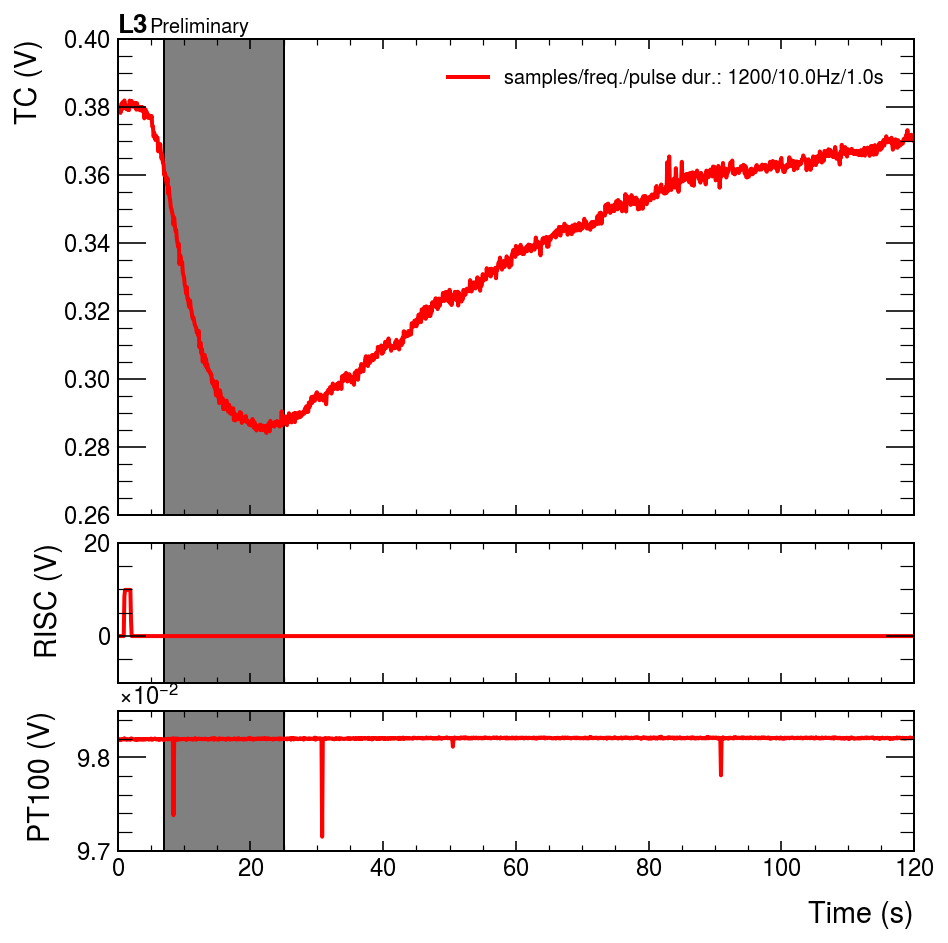

In [37]:
low, up = 7, 25
Analysis(D1).data.prelim_plot(low,up)

Vediamo che per tutti e quattro i casi trattati abbiamo evidenziato una regione per cui potrebbe essere sensata l'approssimazione analitica data precedentemente, per ciu possiamo provare a considerare il grafico linearizzato. Osserviamo allora come sono fetti i grafici di queste quattro casistiche

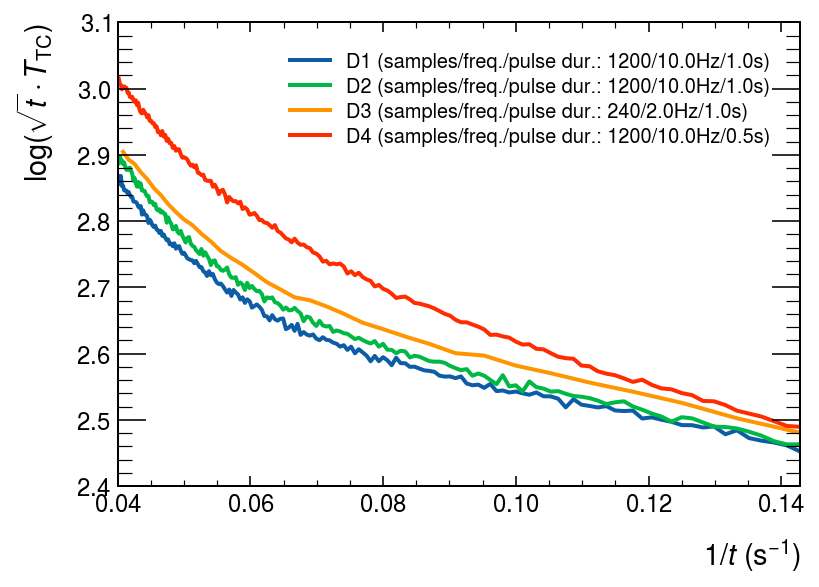

In [38]:
for i, D in enumerate([D1, D2, D3, D4]):
    _, _ = Analysis(D).filter(low, up).plot_linearized()

plt.xlim(1/up, 1/low) # adjust th xlim (broken?)
plt.legend([f'D{i+1} ({Analysis(D).data})' for i, D in enumerate([D1, D2, D3, D4])])

Per il quinto caso anche la regione sembra essere sensata, ma osserviamo che in realtà quello che sembra corretto non risulta in realtà avere perfetto senso quando linearizzato. 

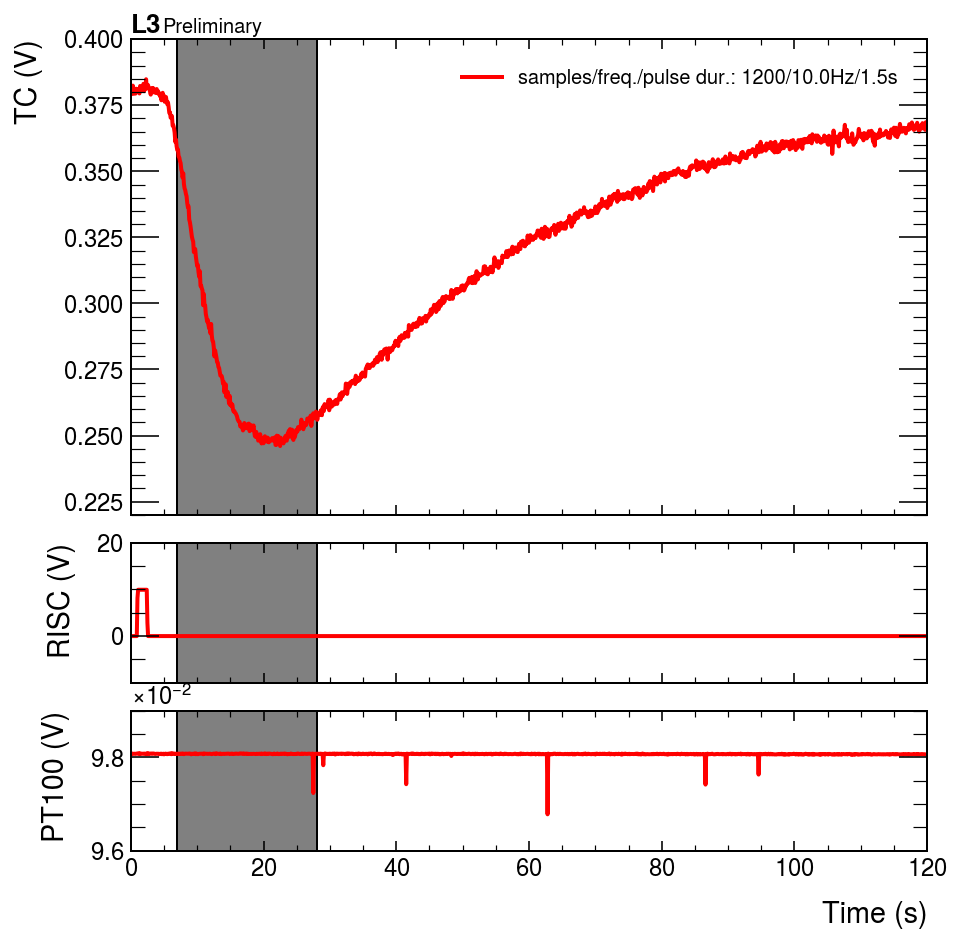

In [7]:
Analysis(D5).data.prelim_plot(low, up)

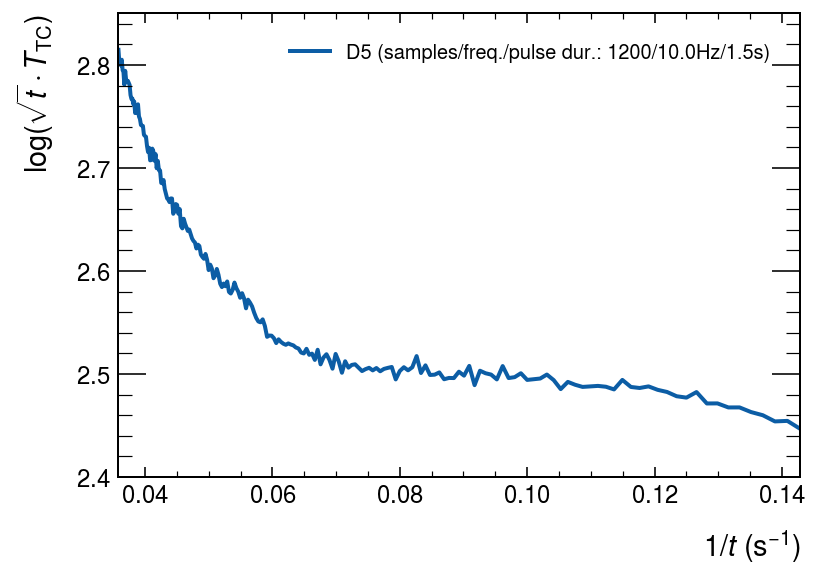

In [34]:
_, _ = Analysis(D5).filter(low, up).plot_linearized()
plt.xlim(1/up, 1/low)
plt.legend([f'D5 ({D5})'])

In questo ultimo caso l'andamento lineare lo otteniamo invece restringendo ancora la finetra, passando infatti a [5, 17] s l'andamento può risultare lineare.

(2.8834104866660205e-05,
 ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.08355 (chi2/ndof = 0.0)  │              Nfcn = 30               │
│ EDM = 1.1e-20 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬

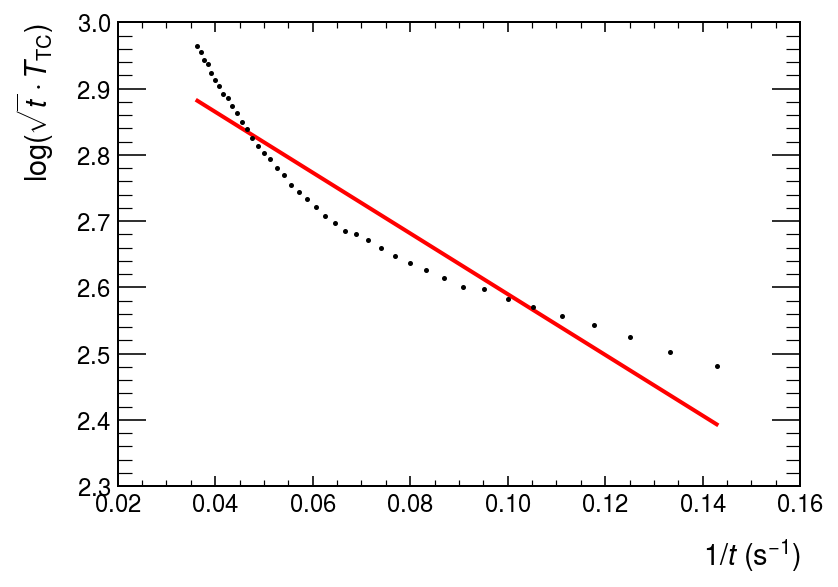

In [32]:
Analysis(D3).filter(low, up).linearized_model_fit(0, -5, 3)

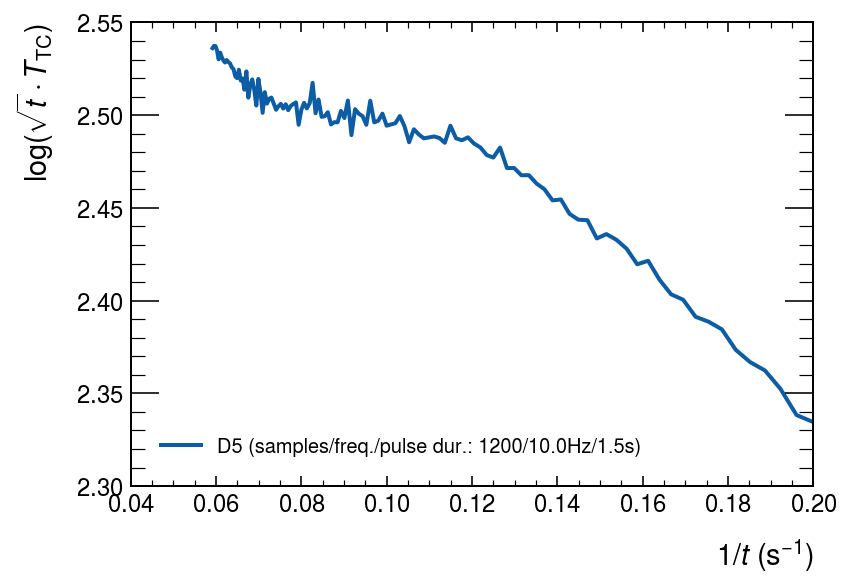

In [10]:
_, _ = Analysis(D5).filter(5, 17).plot_linearized()
# plt.xlim(1/up, 1/low)
plt.legend([f'D5 ({D5.name})'])

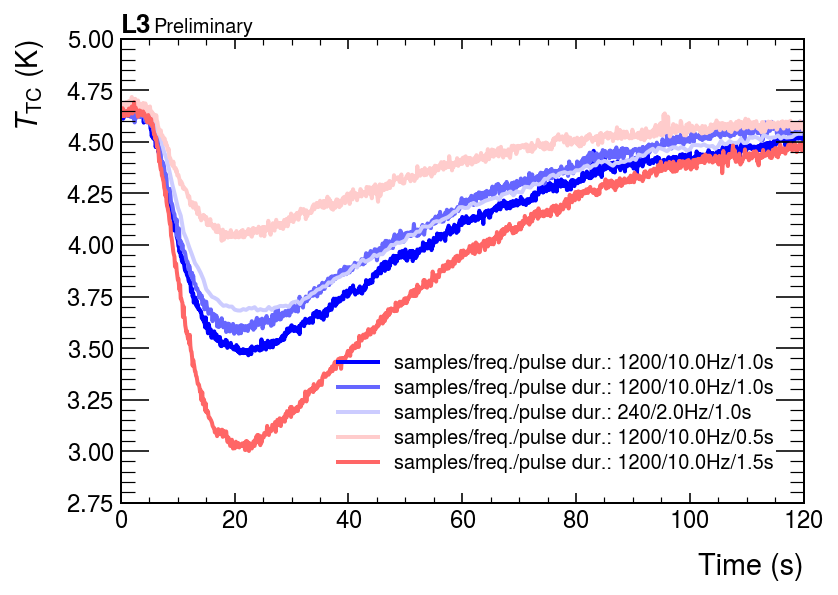

In [11]:
colors = plt.cm.bwr
for i, D in enumerate([D1, D2, D3, D4, D5]):
    plt.plot(D.time[1:], Analysis(D).T('TC')[1:], label=D.name, color=colors(i/5))
plt.xlabel('Time (s)')
plt.ylabel('$T_\mathrm{TC}$ (K)')
hep.label.exp_text('L3','Preliminary')
plt.legend()

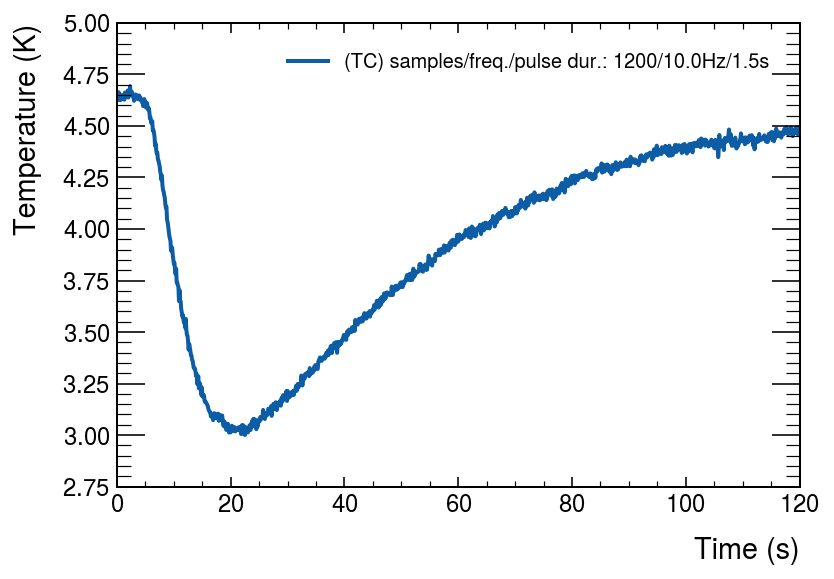

In [12]:
Analysis(D5).plot_temp('TC')
plt.legend()

In [13]:
class Simulation:
    max_time: float = 120
    time_samples: int = 1200
    bar_lenght: float = 63e-3
    lenght_samples: int
    
    delta_lenght: float = 0
    delta_time: float = 0
    
    time_array: np.ndarray
    TC_data_array: np.ndarray
    
    kappa: float = 40
    eta: float
    TC_position: float = 23e-3
    TC_position_index: int
    
    def __init__(self, time, time_samples=1_000_000_000, bar_samples=100, kappa=None, bar_lenght=63e-3):
        if kappa is not None: self.kappa = kappa
        self.time = time
        self.time_samples = time_samples
        self.lenght_samples = bar_samples
        self.delta_time = time / time_samples
        self.delta_lenght = self.bar_lenght / bar_samples
        
        
        self.eta = self.kappa * self.delta_time / self.delta_lenght**2
        if self.eta > 0.5: raise Warning(f'eta {self.eta}>0.5, simulation may diverge')

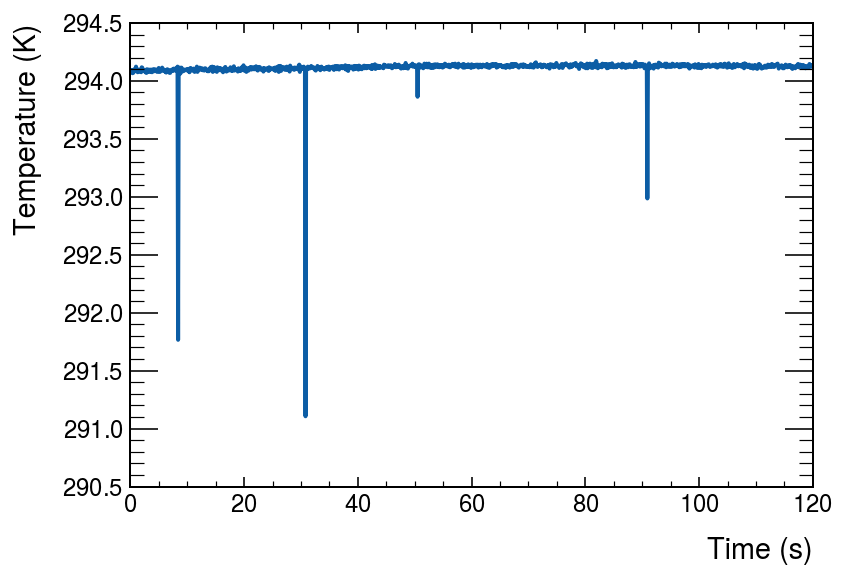

In [36]:
Analysis(D1).plot_temp('PT100')

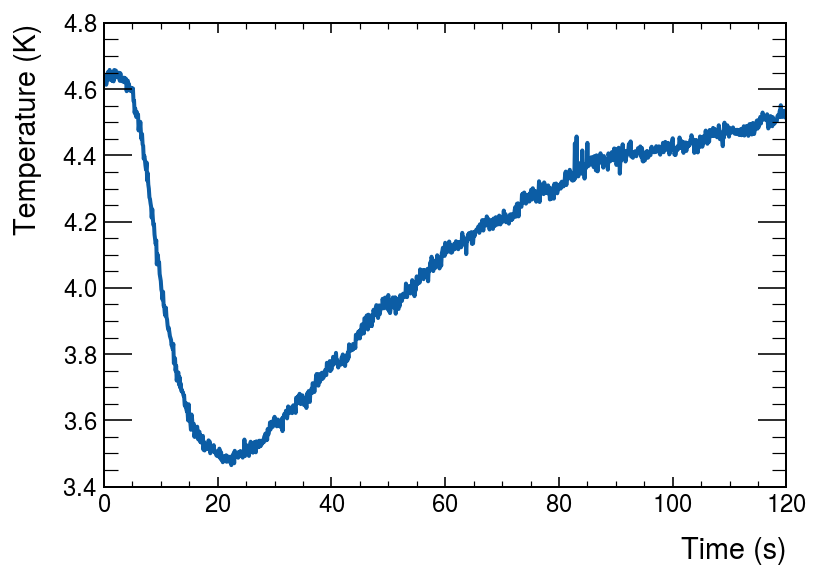

In [39]:
Analysis(D1).plot_temp('TC')